<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot</a></span></li></ul></div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qtensor
import pickle

import time
import sys
sys.path.append('../data/generators/')
import xarray as xar
import miplog_helper

## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

### Helper classes and functions

In [17]:
def log_linear_fit(x, y, x_ext):
    a = np.polyfit(x, np.log(y), deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return np.exp(ln)

def linear_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def cubic_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=3)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def octa_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=6)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

In [28]:
from dataclasses import dataclass

@dataclass
class Line:
    x: np.array 
    y: np.array
        
    def average_flat(self):
        if len(self.y.shape)>1:
            self.std = np.nanstd(self.y, -1)
            self.y = np.nanmean(self.y, -1)
            
@dataclass
class LineFit(Line):
    def log_linear_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = log_linear_fit(self.x, self.y, self.fit_x)
        return self.fit
    
    def cubic_fit(self, x_ext):
        self.fit_x = x_ext
        self.average_flat()
        self.fit = cubic_fit(self.x, self.y, self.fit_x)
        return self.fit

In [29]:
def approx_ratio(p):
    try:
        AR = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']
        if AR>0:
            return AR
        else:
            raise KeyError
    except KeyError:
        AR = 1 - (0.3-np.log2(p)*0.05)
    return AR

def get_data_AR_lower(data, AR, nan_repl=None):
    data
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_lower(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

## Plot

In [30]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

In [59]:
def plot_std_band(x, y, **kwargs):
    mean = np.mean(y, -1)
    std = np.std(y, -1)
    plt.fill_between(x, mean+std, mean-std, **kwargs)
    
def plot_percentile(x, y, perc=10, **kwargs):
    med = np.median(y, -1)
    up = np.percentile(y, 100-perc, -1)
    dn = np.percentile(y, perc, -1)
    plt.fill_between(x, up, dn, **kwargs)

In [62]:
def plot_advantage(p=6, datadir='../data'):
    fig = plt.figure(figsize=(8, 6))

    AR = approx_ratio(p)

    plt.yscale('log')
    plt.xscale('log')
    ## -- plot quantum
    quant = xar.open_dataarray(datadir+'/quantum_nsamples1000_d3.nc')
    x = quant.N
    qaoa_transport = quant.sel(types='transport', p=p)
    qaoa_dst_seq = quant.sel(types='destructive', p=p)

    plt.plot(x, qaoa_transport, color='red',
             label=f'QAOA w/ transport time (quality={np.round(AR, 3)})')
    plt.plot(x, qaoa_dst_seq, color='orange',
             label=f'QAOA w/ destructive sequential time (quality={np.round(AR, 3)})')
    
    gw = xar.open_dataarray(datadir+'/gw_times.nc')
    gwx = gw.N
    plt.plot(gwx, gw.mean('seed'), marker='*', color='green', label='Goemans-Williamson (quality=0.878)')
    plot_std_band(gwx, gw, alpha=0.1, color='green')
    
    opt = xar.open_dataarray(datadir+'/gurobi_opt_threads1.nc')
    plt.plot(opt.N, opt.mean('seeds'), marker='*', color='blue', label='Gurobi: optimal (quality=1.0)')
    plot_percentile(opt.N, opt, alpha=0.1, color='blue')
    

    data_match = pickle.load(open(datadir+'/gurobi_match_threads1.pkl', 'rb'))
    match_p = get_data_AR_lower(data_match, AR, nan_repl=np.inf)
    plt.plot(match_p.N, match_p.mean('seed'), marker='*', color='magenta',
             label=f'Gurobi: match (quality={np.round(AR, 3)})')
    plot_percentile(match_p.N, match_p, alpha=0.1, color='magenta')
    
    
    #plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
    #plt.plot(gw.fit_x, gw.fit, '--', color='black')
    plt.legend(loc='upper left')
    plt.ylabel('Time to solution')
    plt.title(f'p={p}')
    plt.grid()

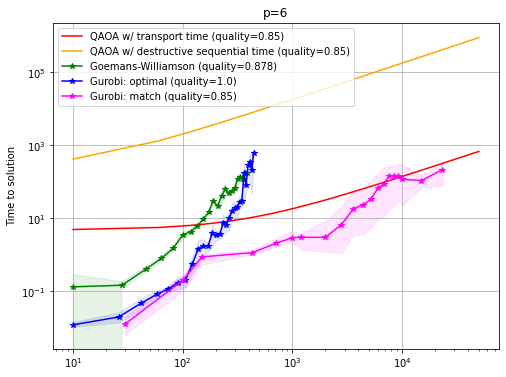

In [63]:
p = 6
plot_advantage(p=p)
plt.savefig(f"./pdf/p{p}_time_vs_n.pdf")

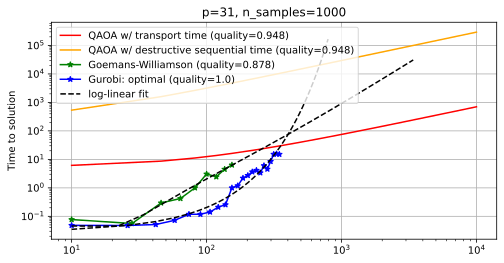

In [24]:
plot_advantage(p=31)